In [396]:
import pandas as pd

def transformToNumber(currency_format):
    # transform $1.230.456,34 to 1230456.34
    currency_format = currency_format.replace(".", "").replace(",", ".").replace("$", "")
    return float(currency_format)

def load_dataframe(file_path):
    df = pd.read_csv(file_path, sep=";", encoding="latin1")
    # trim spaces on column names
    df.columns = df.columns.str.strip()
    df = df.dropna()
    df["Costo Contingente"] = df["Costo Contingente"].apply(transformToNumber)
    df["Month"] = df["Fecha Liquidación"].apply(lambda x: x.split("-")[1])
    df["Year"] = df["Fecha Liquidación"].apply(lambda x: x.split("-")[0])
    # Round to 2 decimal places
    df["Cost_per_beneficiary"] = (df["Costo Contingente"] / df["Beneficiarios"]).round(2)
    return df


data_2025_07 = load_dataframe("dataset/2025-07-pago-del-seguro-de-depositos.csv")



# Join two dataframes
data = data_2025_07.copy()

data.head()


,Ruc,Razón Social,Fecha Liquidación,Sector,Segmento,Provincia,Costo Contingente,Beneficiarios,Month,Year,Cost_per_beneficiary
3,9.906220e+11,"COOPERATIVA DE AHORRO Y CREDITO \ E.T.G.\"" LTD...",2019-01-24,COOP - SFPS,5,GUAYAS,51175.82,86.000,01,2019,595.07
4,4.915081e+11,COOPERATIVA DE AHORRO Y CREDITO 10 DE SEPTIEMB...,2019-12-11,COOP - SFPS,5,CARCHI,3042.82,21.000,12,2019,144.90
5,1.891708e+12,COOPERATIVA DE AHORRO Y CREDITO 15 DE DICIEMBR...,2016-05-16,COOP - SFPS,5,TUNGURAHUA,14458.24,461.000,05,2016,31.36
6,9.913137e+11,COOPERATIVA DE AHORRO Y CREDITO 19 DE SEPTIEMBRE,2018-06-21,COOP - SFPS,5,GUAYAS,72248.46,110.000,06,2018,656.80
7,1.891723e+12,COOPERATIVA DE AHORRO Y CREDITO 21 DE NOVIEMBR...,2020-07-01,COOP - SFPS,5,TUNGURAHUA,43302.50,1.132,07,2020,38253.09


In [397]:
# Remove atypical (outlier) values from data using outlier_mask and outlier_mask_costo
# Define outlier_mask and outlier_mask_costo using IQR method

def get_outlier_mask(series):
	Q1 = series.quantile(0.25)
	Q3 = series.quantile(0.75)
	IQR = Q3 - Q1
	return (series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))

outlier_mask = get_outlier_mask(data["Beneficiarios"])
outlier_mask_costo = get_outlier_mask(data["Costo Contingente"])

# Keep only rows that are not outliers in both columns
clean_data = data[~outlier_mask & ~outlier_mask_costo].copy()

data = clean_data.copy()

clean_data.head()

,Ruc,Razón Social,Fecha Liquidación,Sector,Segmento,Provincia,Costo Contingente,Beneficiarios,Month,Year,Cost_per_beneficiary
3,9.906220e+11,"COOPERATIVA DE AHORRO Y CREDITO \ E.T.G.\"" LTD...",2019-01-24,COOP - SFPS,5,GUAYAS,51175.82,86.000,01,2019,595.07
4,4.915081e+11,COOPERATIVA DE AHORRO Y CREDITO 10 DE SEPTIEMB...,2019-12-11,COOP - SFPS,5,CARCHI,3042.82,21.000,12,2019,144.90
5,1.891708e+12,COOPERATIVA DE AHORRO Y CREDITO 15 DE DICIEMBR...,2016-05-16,COOP - SFPS,5,TUNGURAHUA,14458.24,461.000,05,2016,31.36
6,9.913137e+11,COOPERATIVA DE AHORRO Y CREDITO 19 DE SEPTIEMBRE,2018-06-21,COOP - SFPS,5,GUAYAS,72248.46,110.000,06,2018,656.80
7,1.891723e+12,COOPERATIVA DE AHORRO Y CREDITO 21 DE NOVIEMBR...,2020-07-01,COOP - SFPS,5,TUNGURAHUA,43302.50,1.132,07,2020,38253.09


In [398]:
# Costo Beneficiario por Provincia

data_provincia = clean_data.groupby(["Provincia"])["Cost_per_beneficiary"].mean().round(2).reset_index()
data_provincia = data_provincia.sort_values("Cost_per_beneficiary", ascending=False)


In [399]:
# Media global
costo_promedio_global = data_provincia["Cost_per_beneficiary"].mean().round(2)
costo_promedio_global


np.float64(10271.52)

In [400]:

from ydata_profiling import ProfileReport

profile = ProfileReport(data, explorative=True)
profile.to_file("reporte.html")



Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [401]:
# create new dataframe where sum of Costo Contingente and beneficiarios by Year 
data_yearly = clean_data.groupby(["Year"])["Costo Contingente"].sum().reset_index()
data_yearly["Beneficiarios"] = clean_data.groupby(["Year"])["Beneficiarios"].sum().values
# Count the number of cooperativas by year
data_yearly["Total_Cooperativas"] = clean_data.groupby(["Year"]).size().values
data_yearly["costo promedio por beneficiario"] = (data_yearly["Costo Contingente"] / data_yearly["Beneficiarios"] )
data_yearly



,Year,Costo Contingente,Beneficiarios,Total_Cooperativas,costo promedio por beneficiario
0,2013,337016.33,1069.000,5,315.263171
1,2014,734924.29,1767.395,15,415.823452
2,2015,660262.35,2050.649,14,321.977262
3,2016,3205620.96,14620.402,75,219.256691
4,2017,1306677.22,2885.474,21,452.846645
5,2018,1340108.37,5447.482,17,246.005103
6,2019,479529.98,1023.235,9,468.641104
7,2020,685205.84,1001.381,11,684.260876
8,2021,405069.72,1803.779,11,224.567267
9,2022,682070.30,1878.064,8,363.177346


In [402]:
# Promedio global del costo por beneficiario
avg_global_costo_benef = data_yearly["costo promedio por beneficiario"].mean().round(2)
print("Promedio global del costo por beneficiario:", avg_global_costo_benef)

Promedio global del costo por beneficiario: 538.2


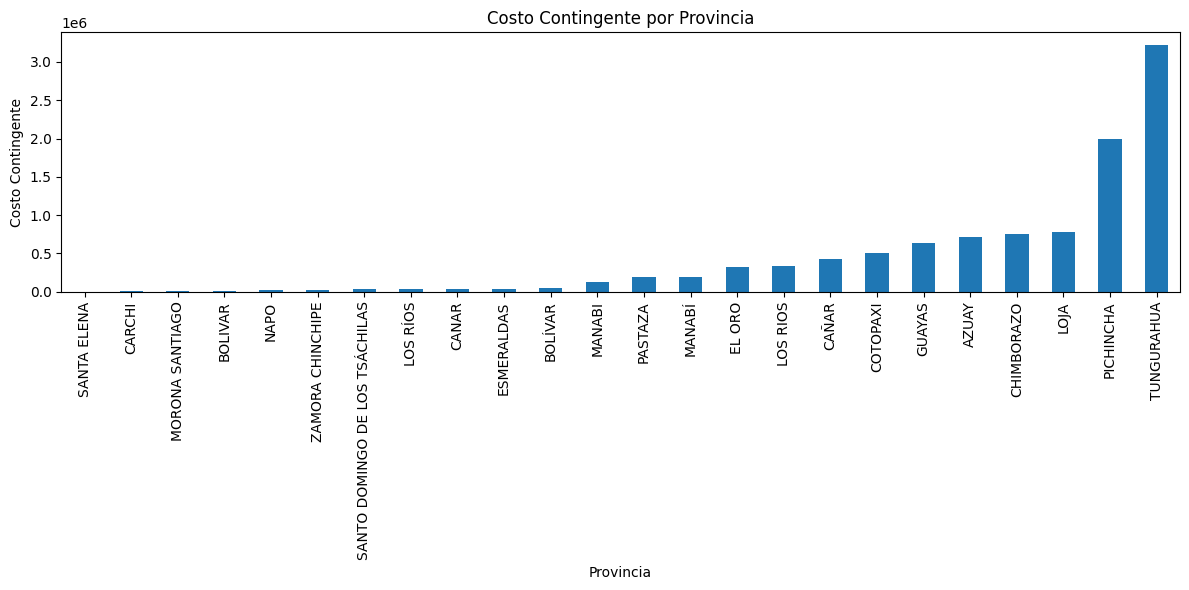

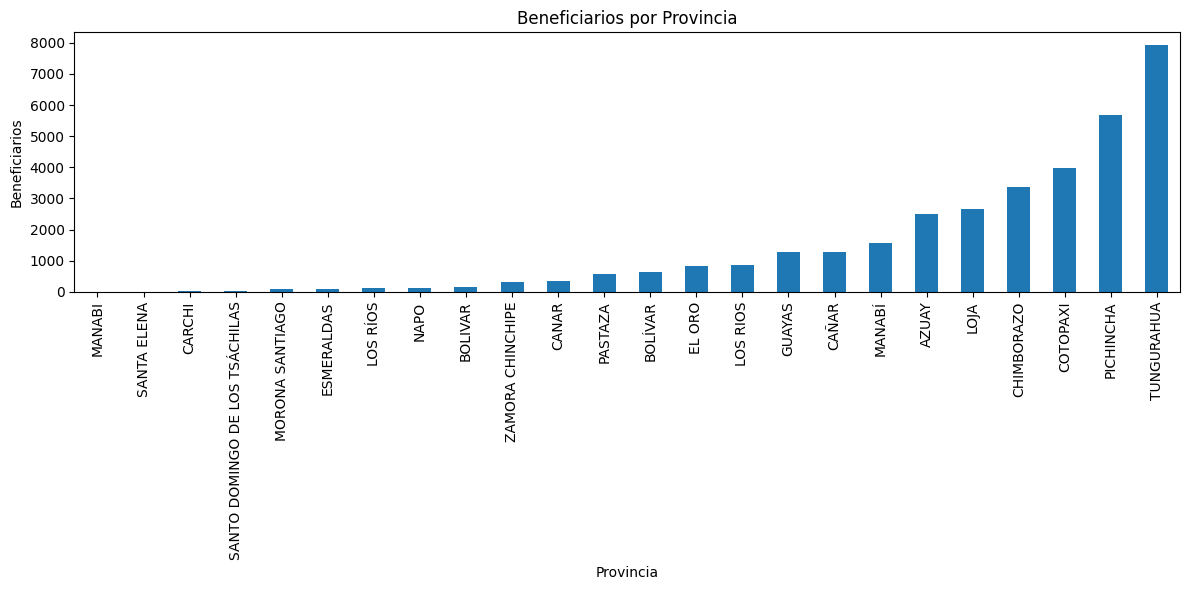

<Figure size 1200x600 with 0 Axes>

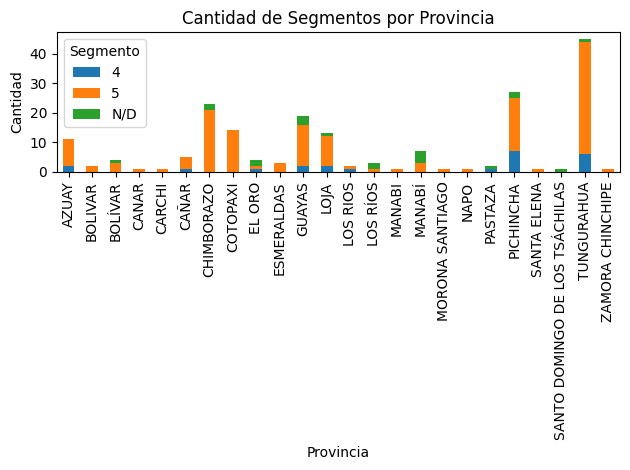

In [403]:
import matplotlib.pyplot as plt

# Provincia vs Costo Contingente
plt.figure(figsize=(12,6))
data.groupby('Provincia')['Costo Contingente'].sum().sort_values().plot(kind='bar')
plt.title('Costo Contingente por Provincia')
plt.ylabel('Costo Contingente')
plt.xlabel('Provincia')
plt.tight_layout()
plt.show()

# Provincia vs Beneficiarios
plt.figure(figsize=(12,6))
data.groupby('Provincia')['Beneficiarios'].sum().sort_values().plot(kind='bar')
plt.title('Beneficiarios por Provincia')
plt.ylabel('Beneficiarios')
plt.xlabel('Provincia')
plt.tight_layout()
plt.show()

# Provincia vs Segmento (conteo)
plt.figure(figsize=(12,6))
data.groupby(['Provincia', 'Segmento']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Cantidad de Segmentos por Provincia')
plt.ylabel('Cantidad')
plt.xlabel('Provincia')
plt.tight_layout()
plt.show()

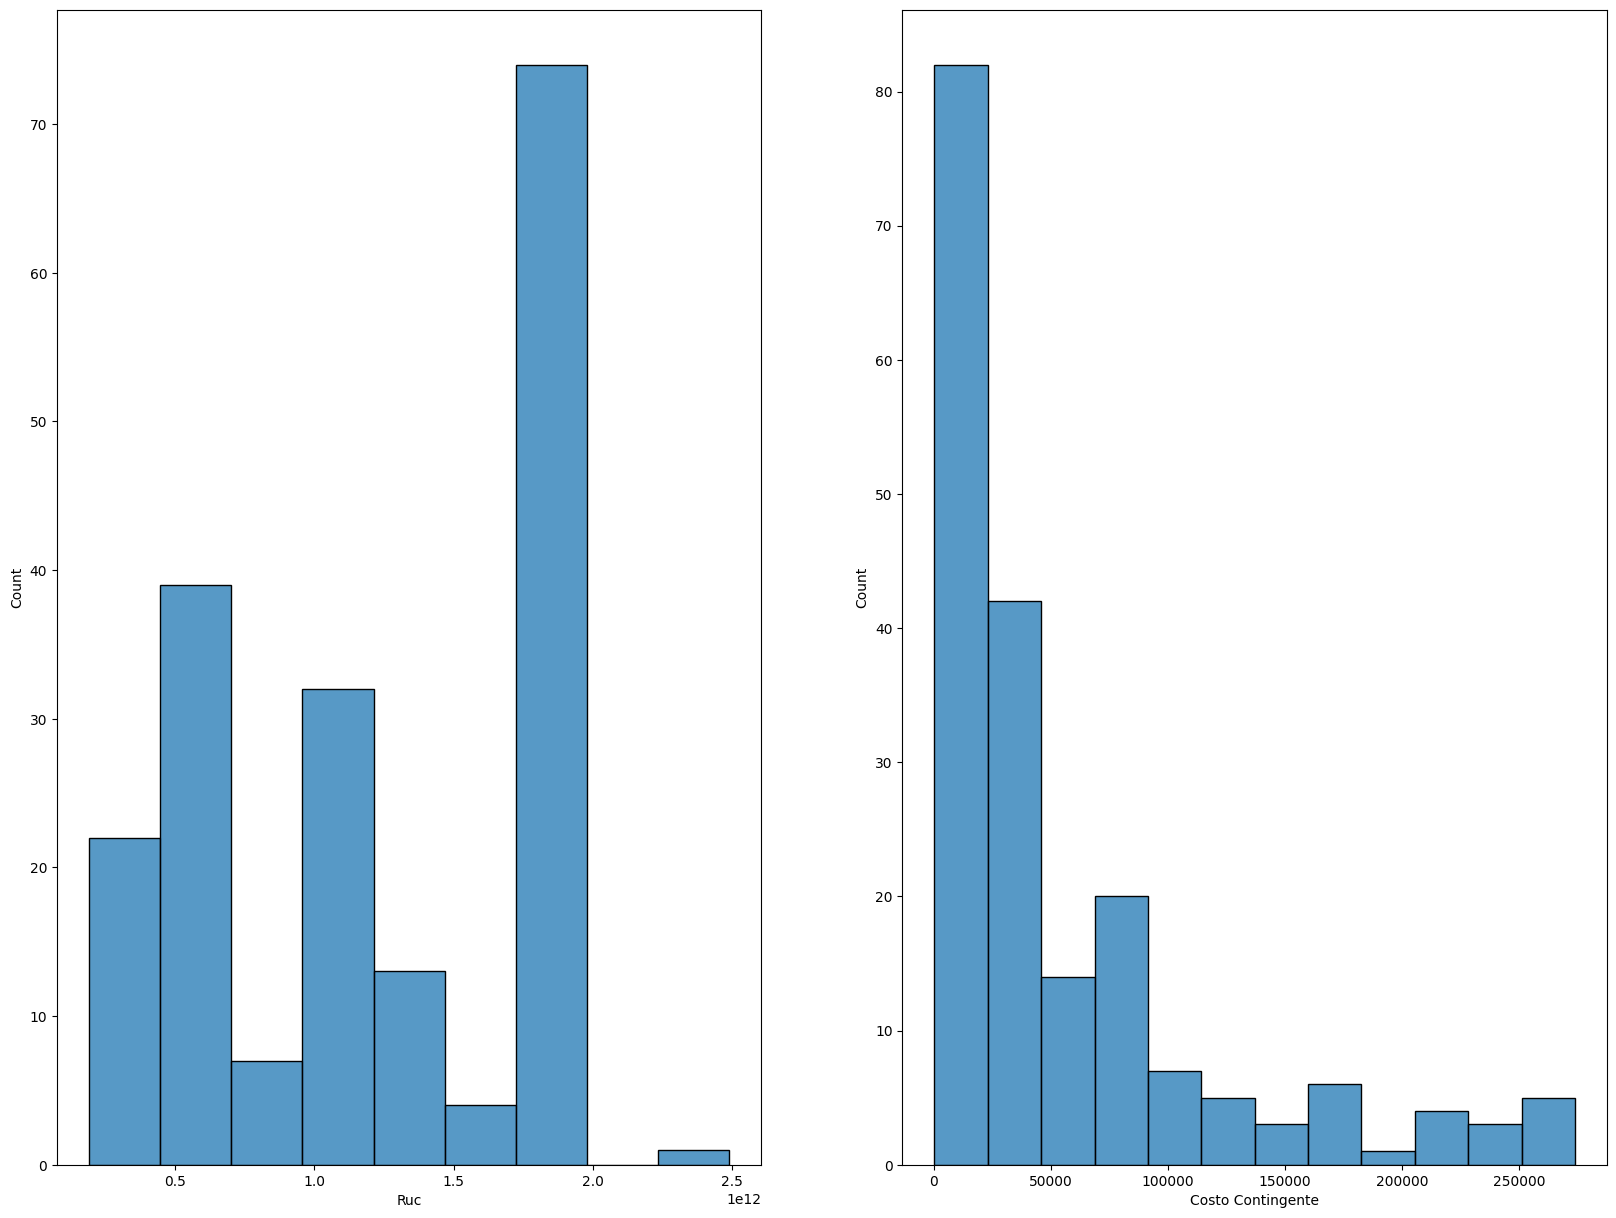

In [404]:
import seaborn as sns
import matplotlib.pyplot as plt


# detección de valores atípicos
numerical_col = data.select_dtypes(include=['int', 'float']).columns
plt.figure
fig, ax = plt.subplots(1,2, figsize=(20,15))

# tenemos 4 valores numéricos.
row, col = 1,2
col_count = 0
for c in range(col):
    if col_count >= len(numerical_col):
        ax[c].text(0.5, 0.5, "no data")
    else:
        sns.histplot(data=data, x=numerical_col[col_count], ax=ax[c])
    col_count += 1

# sns and plt display on notebook


In [405]:
from sklearn.preprocessing import LabelEncoder

data_kmeans = data.copy()

# Etiquetado de variables categoricas como Provincia use Label Encoder

le = LabelEncoder()
data_kmeans['Provincia'] = le.fit_transform(data_kmeans['Provincia'])
data_kmeans["Cooperativa"] = le.fit_transform(data_kmeans["Razón Social"])

data_kmeans.head()


,Ruc,Razón Social,Fecha Liquidación,Sector,Segmento,Provincia,Costo Contingente,Beneficiarios,Month,Year,Cost_per_beneficiary,Cooperativa
3,9.906220e+11,"COOPERATIVA DE AHORRO Y CREDITO \ E.T.G.\"" LTD...",2019-01-24,COOP - SFPS,5,10,51175.82,86.000,01,2019,595.07,188
4,4.915081e+11,COOPERATIVA DE AHORRO Y CREDITO 10 DE SEPTIEMB...,2019-12-11,COOP - SFPS,5,4,3042.82,21.000,12,2019,144.90,0
5,1.891708e+12,COOPERATIVA DE AHORRO Y CREDITO 15 DE DICIEMBR...,2016-05-16,COOP - SFPS,5,22,14458.24,461.000,05,2016,31.36,1
6,9.913137e+11,COOPERATIVA DE AHORRO Y CREDITO 19 DE SEPTIEMBRE,2018-06-21,COOP - SFPS,5,10,72248.46,110.000,06,2018,656.80,2
7,1.891723e+12,COOPERATIVA DE AHORRO Y CREDITO 21 DE NOVIEMBR...,2020-07-01,COOP - SFPS,5,22,43302.50,1.132,07,2020,38253.09,3


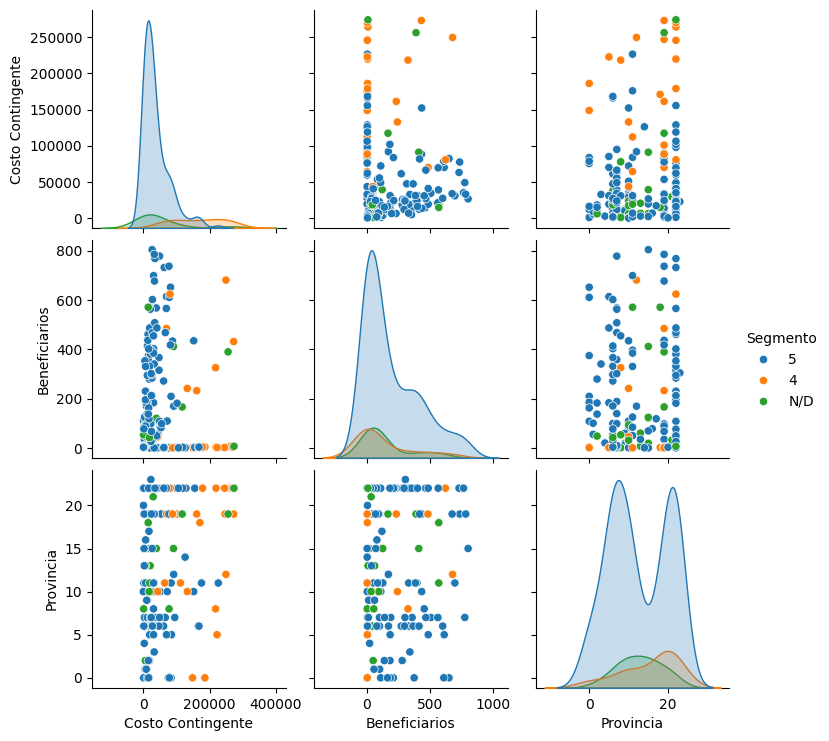

In [406]:
col = ["Costo Contingente", "Beneficiarios", "Provincia","Segmento"]
sns.pairplot(data=data_kmeans[col], hue="Segmento")

In [407]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Seleccionamos las columnas numéricas relevantes
X = data_kmeans[["Costo Contingente", "Beneficiarios", "Provincia", "Cooperativa"]]

# Escalamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ajustamos KMeans (por ejemplo, 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
data_kmeans['cluster'] = kmeans.fit_predict(X_scaled)

# Calculamos la distancia de cada punto a su centroide
distances = kmeans.transform(X_scaled)
data_kmeans['distance_to_centroid'] = distances[np.arange(len(X_scaled)), data_kmeans['cluster']]

# Definimos anomalías como los puntos más alejados de su centroide (top 5%)
threshold = data_kmeans['distance_to_centroid'].quantile(0.95)
anomalies = data_kmeans[data_kmeans['distance_to_centroid'] > threshold]

print("Número de anomalías detectadas:", len(anomalies))


Número de anomalías detectadas: 10


In [408]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Selección de features relevantes (ajustar según disponibilidad real)
features = [
    'Provincia', 'Cooperativa', 'Segmento', "Costo Contingente", "Beneficiarios"
]
target_costo = 'Costo Contingente'
target_benef = 'Beneficiarios'

# Filtrar solo filas con datos completos para las variables seleccionadas
df_model = data_kmeans.dropna(subset=features + [target_costo, target_benef])

X = df_model[features]
y_costo = df_model[target_costo]
y_benef = df_model[target_benef]

# Codificar variables categóricas si es necesario
X = pd.get_dummies(X, drop_first=True)

# Split para entrenamiento y test
X_train, X_test, y_costo_train, y_costo_test = train_test_split(X, y_costo, test_size=0.2, random_state=42)
_, _, y_benef_train, y_benef_test = train_test_split(X, y_benef, test_size=0.2, random_state=42)

# Modelo 1: Ridge Regression (regularizada)
ridge = Ridge()
ridge.fit(X_train, y_costo_train)
y_costo_pred_ridge = ridge.predict(X_test)

# Modelo 2: Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_costo_train)
y_costo_pred_gb = gb.predict(X_test)

# Evaluación
print("Ridge RMSE:", mean_squared_error(y_costo_test, y_costo_pred_ridge))
print("Ridge R2:", r2_score(y_costo_test, y_costo_pred_ridge))
print("GB RMSE:", mean_squared_error(y_costo_test, y_costo_pred_gb))
print("GB R2:", r2_score(y_costo_test, y_costo_pred_gb))

# Repetir para beneficiarios esperados
ridge_b = Ridge()
ridge_b.fit(X_train, y_benef_train)
y_benef_pred_ridge = ridge_b.predict(X_test)

gb_b = GradientBoostingRegressor(random_state=42)
gb_b.fit(X_train, y_benef_train)
y_benef_pred_gb = gb_b.predict(X_test)

print("Beneficiarios Ridge RMSE:", mean_squared_error(y_benef_test, y_benef_pred_ridge))
print("Beneficiarios Ridge R2:", r2_score(y_benef_test, y_benef_pred_ridge))
print("Beneficiarios GB RMSE:", mean_squared_error(y_benef_test, y_benef_pred_gb))
print("Beneficiarios GB R2:", r2_score(y_benef_test, y_benef_pred_gb))

# Uso: para nuevas señales de estrés, predecir severidad y beneficiarios esperados
# Ejemplo:
# new_signals = pd.DataFrame([...]) # con las mismas columnas que 'features'
# new_signals_encoded = pd.get_dummies(new_signals, drop_first=True).reindex(columns=X.columns, fill_value=0)
# costo_estimado = gb.predict(new_signals_encoded)
# beneficiarios_estimados = gb_b.predict(new_signals_encoded)

Ridge RMSE: 1.516057672240708e-14
Ridge R2: 1.0
GB RMSE: 1230327.8647817888
GB R2: 0.9997096626746165
Beneficiarios Ridge RMSE: 1.2406504096181236e-09
Beneficiarios Ridge R2: 0.9999999999999768
Beneficiarios GB RMSE: 12.288123215383305
Beneficiarios GB R2: 0.9997706384217556


In [409]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Selección de features relevantes
features = ['Provincia', 'Segmento', 'Costo Contingente', 'Beneficiarios']
target = 'Costo Contingente'

# Codificar variables categóricas
X = data[features]
X = pd.get_dummies(X, drop_first=True)
y = data[target]

# Split de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge Regression
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

# Evaluación
print("Ridge RMSE:", mean_squared_error(y_test, y_pred_ridge))
print("Ridge R2:", r2_score(y_test, y_pred_ridge))
print("GB RMSE:", mean_squared_error(y_test, y_pred_gb))
print("GB R2:", r2_score(y_test, y_pred_gb))

Ridge RMSE: 1.9359588676140483e-14
Ridge R2: 1.0
GB RMSE: 1161659.9458001489
GB R2: 0.9997258671844121


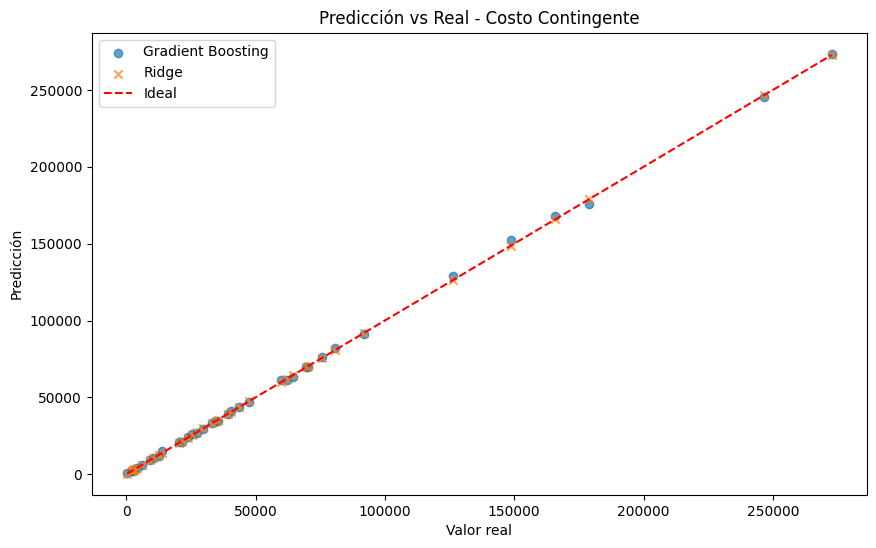

Gradient Boosting RMSE: 1161659.9458001489
Gradient Boosting R2: 0.9997258671844121
Ridge RMSE: 1.9359588676140483e-14
Ridge R2: 1.0


In [410]:
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Visualización y evaluación del modelo de regresión

import matplotlib.pyplot as plt

# 1. Visualización: Gráfico de dispersión real vs predicho para Costo Contingente
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_gb, alpha=0.7, label='Gradient Boosting')
plt.scatter(y_test, y_pred_ridge, alpha=0.7, label='Ridge', marker='x')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.title('Predicción vs Real - Costo Contingente')
plt.legend()
plt.show()

# 2. Métricas de desempeño

print("Gradient Boosting RMSE:", mean_squared_error(y_test, y_pred_gb))
print("Gradient Boosting R2:", r2_score(y_test, y_pred_gb))
print("Ridge RMSE:", mean_squared_error(y_test, y_pred_ridge))
print("Ridge R2:", r2_score(y_test, y_pred_ridge))

# 3. Interpretación rápida:
# - RMSE (Root Mean Squared Error) mide el error promedio de predicción (menor es mejor).
# - R2 (Coeficiente de determinación) mide qué tan bien el modelo explica la variabilidad (más cercano a 1 es mejor).
# - El gráfico muestra qué tan cerca están las predicciones de los valores reales (la línea roja es el ideal).